In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from ipywidgets import interact
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from tensorflow.keras.utils import register_keras_serializable

from Training_Data.Particle_Tracking_Training_Data import Particle_Tracking_Training_Data

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\conda\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
c:\conda\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
c:\conda\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
c:\conda\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top
c:\

In [3]:
def build_multi_kernel_conv_model():

    # Two inputs images, one is the current frame image, the other is the previous frame image
    input_current = tf.keras.Input(shape=(256, 256, 1))

    input_previous = tf.keras.Input(shape=(256, 256, 1))

    # In the following two layers, we have several shared branches for both inputs.

    #######################################################################################################
    ###########################################   Layer 1 #################################################
    #######################################################################################################

    # 分支1：9×9 卷积核，输出通道设为 3（可根据需求调整）
    branch1_share = layers.Conv2D(filters=3,
                            kernel_size=(9, 9),
                            strides=2,
                            padding='same',
                            activation='elu')
    # 分支2：5×5 卷积核，输出通道设为 3
    branch2_share = layers.Conv2D(filters=3,
                            kernel_size=(5, 5),
                            strides=2,
                            padding='same',
                            activation='elu')

    # 分支3：3×3 卷积核，输出通道设为 3
    branch3_share = tf.keras.Sequential([
        layers.Conv2D(filters=3, kernel_size=(3, 3), strides=2, padding='same', activation='elu'),
        layers.MaxPooling2D(pool_size=3, strides=1, padding='same')
    ])

    # Applying sharing branches to both inputs

    # Current input image in layer 1
    conv1_current = branch1_share(input_current)
    conv2_current = branch2_share(input_current)
    conv3_current = branch3_share(input_current)

    # Previous input image in layer 1
    conv1_previous = branch1_share(input_previous)
    conv2_previous = branch2_share(input_previous)
    conv3_previous = branch3_share(input_previous)

    outputs1_current = layers.Concatenate(axis=-1)([conv1_current, conv2_current, conv3_current])
    outputs1_previous = layers.Concatenate(axis=-1)([conv1_previous, conv2_previous, conv3_previous])

    #######################################################################################################
    ###########################################   Layer 2 #################################################
    #######################################################################################################

    inputs2_current = outputs1_current
    inputs2_previous = outputs1_previous

    #branch 4: 7*7 convolution kernel, channels = 6
    branch4_share = layers.Conv2D(filters=6,
                            kernel_size=(7, 7),
                            strides=1,
                            padding='same',
                            activation='elu')

    #branch 5: 3*3 convolution kernel, channels = 6
    branch5 = layers.Conv2D(filters=6,
                            kernel_size=(3, 3),
                            strides=1,
                            padding='same',
                            activation='elu')

    # Applying layer and shared layer to both inputs
    conv4_current = branch4_share(inputs2_current)
    conv5_current = branch5(inputs2_current)

    conv4_previous = branch4_share(inputs2_previous)

    #######################################################################################################
    ########################################    Recurrent layer   #########################################
    #######################################################################################################

    # Recurrent layer
    branch_recurrent = tf.keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(7, 7), strides=1, dilation_rate=2, padding='same', activation='elu'),
        layers.Conv2D(filters=6, kernel_size=(7, 7), strides=1, dilation_rate=3, padding='same', activation='elu')
    ])

    # Applying the recurrent layer to previous input
    conv_recurrent = branch_recurrent(conv4_previous)


    # Output for layer 2, output channel = 18
    outputs2 = layers.Concatenate(axis=-1)([conv4_current, conv5_current, conv_recurrent])

    #######################################################################################################
    ###########################################   Layer 3 #################################################
    #######################################################################################################

    # Fully connected layer with 5×5 kernel, finalizing to 2 output channels (background vs particle)
    final_layer = layers.Conv2D(filters=2, kernel_size=(5, 5), padding='same', activation='elu')

    # Apply final layer
    conv6 = final_layer(outputs2)


    # Final output, applying softmax
    outputs = layers.Softmax(axis=1, name="prob_map")(conv6)


    # 构建模型
    model = Model(inputs=[input_current, input_previous],
                  outputs=outputs,
                  name="multi_kernel_conv")
    return model

In [4]:
Nt = 100 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image
a = 3. ## scale factor for the size of particle spots (not true size of particles)
IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1)
Nparticles = 10 ## the number of particles (more => slower)
sigma_motion = 2.3 ## the standard deviation for particle brownian motion; should be in (0, 10)

## you might consider randomizing some of these parameters when training a neural net

pt = Particle_Tracking_Training_Data(Nt) ## create object instance
## you can 'call' the object as many times as you want
## in this example, we only generate one training example
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion)

In [5]:
# 创建并查看模型结构
model = build_multi_kernel_conv_model()
model.summary()

# 2. 生成一个随机输入 (batch_size=1, 256×256, 通道数=1)
frame_0 = tf.expand_dims(tf.expand_dims(vid[0], axis=0), axis=-1)
frame_1 = tf.expand_dims(tf.expand_dims(vid[1], axis=0), axis=-1)
y1 = model([frame_0, frame_1])
print("输入形状:", frame_0.shape)
print("输出形状:", y1.shape)

Model: "multi_kernel_conv"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 3)  246         ['input_1[0][0]',                
                                                                  'input_2[0][0]']

In [6]:
X_curr = []
X_prev = []
Y_labels = []

for i in range(1, Nt):
    # 当前帧 shape (256,256,1)
    curr = tf.expand_dims(vid[i],   axis=-1)
    # 前一帧 shape (256,256,1)
    prev = tf.expand_dims(vid[i-1], axis=-1)

    X_curr.append(curr)
    X_prev.append(prev)

    Y_labels.append(labels[i])  # 对应当前帧的标签

X_curr = tf.stack(X_curr, axis=0)  # (Nt-1, 256,256,1)
X_prev = tf.stack(X_prev, axis=0)  # (Nt-1, 256,256,1)
Y_labels = tf.stack(Y_labels, axis=0)

In [7]:
class OneHotMeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        # total_confusion_matrix 的形状为 [num_classes, num_classes]
        self.total_cm = self.add_weight(
            name='total_confusion_matrix',
            shape=(num_classes, num_classes),
            initializer='zeros',  # 或 tf.zeros_initializer()
            dtype=tf.float32
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        y_true, y_pred: (batch, height, width, num_classes) 的 one-hot。
        这里先将 one-hot 转成整型类别索引，再更新混淆矩阵。
        """
        y_true_argmax = tf.argmax(y_true, axis=-1)
        y_pred_argmax = tf.argmax(y_pred, axis=-1)

        y_true_argmax = tf.reshape(y_true_argmax, [-1])
        y_pred_argmax = tf.reshape(y_pred_argmax, [-1])

        current_cm = tf.math.confusion_matrix(
            y_true_argmax,
            y_pred_argmax,
            num_classes=self.num_classes,
            weights=sample_weight,
            dtype=tf.float32
        )
        self.total_cm.assign_add(current_cm)

    def result(self):
        # mean IoU = average over (true_positives / union)
        sum_over_row = tf.reduce_sum(self.total_cm, axis=0)
        sum_over_col = tf.reduce_sum(self.total_cm, axis=1)
        true_positives = tf.linalg.diag_part(self.total_cm)
        denominator = sum_over_row + sum_over_col - true_positives
        iou = true_positives / denominator
        return tf.reduce_mean(iou)

    def reset_states(self):
        # 每个 epoch 前自动重置
        tf.keras.backend.batch_set_value(
            [(v, tf.zeros_like(v)) for v in self.variables]
        )


In [ ]:
# X_curr, X_prev, Y_labels 的第一维是 batch_size = (Nt-1), 

# 1. 定义指数衰减的学习率调度
initial_lr = 0.16
decay_rate = 0.95
decay_steps = 1000 

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True  # 若为 True，则每到达 decay_steps 后才跳变；False 表示连续光滑衰减
)

# 2. 定义优化器为 SGD，并使用 lr_schedule 作为学习率
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

# 3. 编译模型
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        'accuracy',
        OneHotMeanIoU(num_classes=2)  # 二分类示例
    ]
)

Different ways to fit the model

In [9]:
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.utils import Sequence


class MyDataGenerator(Sequence):
    def __init__(self, pt_instance, batch_size, steps_per_epoch):
        """
        pt_instance: 一个你用来生成合成数据的实例，比如 Particle_Tracking_Training_Data(Nt)
        batch_size: 每个batch的大小
        steps_per_epoch: 每个epoch的 batch 数量
        """
        self.pt = pt_instance
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch

        # 第一次生成数据
        self.on_epoch_end()

    def __len__(self):
        # 每次 epoch 中的 batch 数量
        return self.steps_per_epoch

    def __getitem__(self, index):
        # 从 self.X_curr, self.X_prev, self.Y_labels 中取出第 index 个 batch
        start_i = index * self.batch_size
        end_i = start_i + self.batch_size

        batch_X_curr = self.X_curr[start_i:end_i]
        batch_X_prev = self.X_prev[start_i:end_i]
        batch_Y = self.Y_labels[start_i:end_i]

        return ((batch_X_curr, batch_X_prev), batch_Y)

    def on_epoch_end(self):
        """
        每个 epoch 结束后自动调用
        - 在这里可以重新生成一整套 (Nt-1) 帧的合成数据，
          或者打乱已有数据的顺序
        """
        Nt = 100 ## number of frames for each video
        kappa = 0.1 ## standard deviation of background noise added to image
        a = 3 ## scale factor for the size of particle spots (not true size of particles)
        IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1)
        Nparticles = 10 ## the number of particles (more => slower)
        sigma_motion = 2.3 ## the standard deviation for particle brownian motion; should be in (0, 10)

        vid, labels, tracks = self.pt(kappa, a, IbackLevel, Nparticles, sigma_motion)   # 根据需要传参

        # (Nt-1, 256,256,1) ...
        X_curr = []
        X_prev = []
        Y_labels = []
        for i in range(1, Nt):
            curr = np.expand_dims(vid[i],   axis=-1)  # (256,256,1)
            prev = np.expand_dims(vid[i-1], axis=-1)
            X_curr.append(curr)
            X_prev.append(prev)
            Y_labels.append(labels[i])

        self.X_curr = np.stack(X_curr, axis=0)
        self.X_prev = np.stack(X_prev, axis=0)
        self.Y_labels = np.stack(Y_labels, axis=0)

        idx = np.arange(self.X_curr.shape[0])
        np.random.shuffle(idx)
        self.X_curr = self.X_curr[idx]
        self.X_prev = self.X_prev[idx]
        self.Y_labels = self.Y_labels[idx]

# 使用
batch_size = 4
steps_per_epoch = 25  
pt_instance = Particle_Tracking_Training_Data(Nt=100) 

train_gen = MyDataGenerator(pt_instance, batch_size=batch_size, steps_per_epoch=steps_per_epoch)

history = model.fit(
    train_gen,
    epochs=300
)


Epoch 1/300
25/25 [==============================] - 3s 64ms/step - loss: 0.6943 - accuracy: 0.9721 - mean_iou: 0.4861
Epoch 2/300
 2/25 [=>............................] - ETA: 1s - loss: 0.6942 - accuracy: 0.9714 - mean_iou: 0.4881

c:\conda\envs\tf\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric OneHotMeanIoU implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


25/25 [==============================] - 2s 71ms/step - loss: 0.6941 - accuracy: 0.9730 - mean_iou: 0.4901
Epoch 3/300
25/25 [==============================] - 2s 65ms/step - loss: 0.6940 - accuracy: 0.9775 - mean_iou: 0.4955
Epoch 4/300
25/25 [==============================] - 2s 62ms/step - loss: 0.6938 - accuracy: 0.9718 - mean_iou: 0.4982
Epoch 5/300
25/25 [==============================] - 2s 69ms/step - loss: 0.6938 - accuracy: 0.9816 - mean_iou: 0.5092
Epoch 6/300
25/25 [==============================] - 2s 65ms/step - loss: 0.6936 - accuracy: 0.9794 - mean_iou: 0.5132
Epoch 7/300
25/25 [==============================] - 2s 67ms/step - loss: 0.6936 - accuracy: 0.9809 - mean_iou: 0.5151
Epoch 8/300
25/25 [==============================] - 2s 72ms/step - loss: 0.6937 - accuracy: 0.9740 - mean_iou: 0.5053
Epoch 9/300
25/25 [==============================] - 2s 62ms/step - loss: 0.6935 - accuracy: 0.9562 - mean_iou: 0.4990
Epoch 10/300
25/25 [==============================] - 2s 63m

In [ ]:
Nt = 100 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image
a = 3. ## scale factor for the size of particle spots (not true size of particles)
IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1)
Nparticles = 10 ## the number of particles (more => slower)
sigma_motion = 2.3 ## the standard deviation for particle brownian motion; should be in (0, 10)

## you might consider randomizing some of these parameters when training a neural net

pt = Particle_Tracking_Training_Data(Nt) ## create object instance
## you can 'call' the object as many times as you want
## in this example, we only generate one training example
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 

x_test = []
x_p = []
y_test = []

for i in range(0, Nt):
    curr = tf.expand_dims(vid[i],   axis=-1)
    pre = tf.expand_dims(vid[i-1], axis=-1)
    
    x_test.append(curr)
    x_p.append(pre)
    
    y_test.append(labels[i])  

x_test = tf.stack(x_test, axis=0)  # (Nt-1, 256,256,1)
x_p = tf.stack(x_p, axis=0)  # (Nt-1, 256,256,1)
y_test = tf.stack(y_test, axis=0)

In [24]:
model.evaluate([x_test, x_p], y_test, batch_size=32)

1/4 [======>.......................] - ETA: 0s - loss: 0.6929 - accuracy: 0.9898 - mean_iou: 0.5569

c:\conda\envs\tf\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric OneHotMeanIoU implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


4/4 [==============================] - 0s 94ms/step - loss: 0.6929 - accuracy: 0.9902 - mean_iou: 0.5599


[0.6929187774658203, 0.9902300834655762, 0.559874951839447]

In [25]:
predictions = model.predict([x_test, x_p])

4/4 [==============================] - 0s 72ms/step


In [ ]:
@interact(t=(0, Nt-2, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(131)
    imshow(vid[t], origin='lower')
    if show_tracks:
        plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
    xlim(-10, 265)
    ylim(-10, 265)

    fig.add_subplot(132)
    imshow(vid[t], origin='lower')
    imshow(labels[t, ..., 1], origin='lower')

    fig.add_subplot(133)
    imshow(vid[t], origin='lower')
    imshow(predictions[t, ..., 1], origin='lower')

interactive(children=(IntSlider(value=0, description='t', max=98), Checkbox(value=True, description='show_trac…

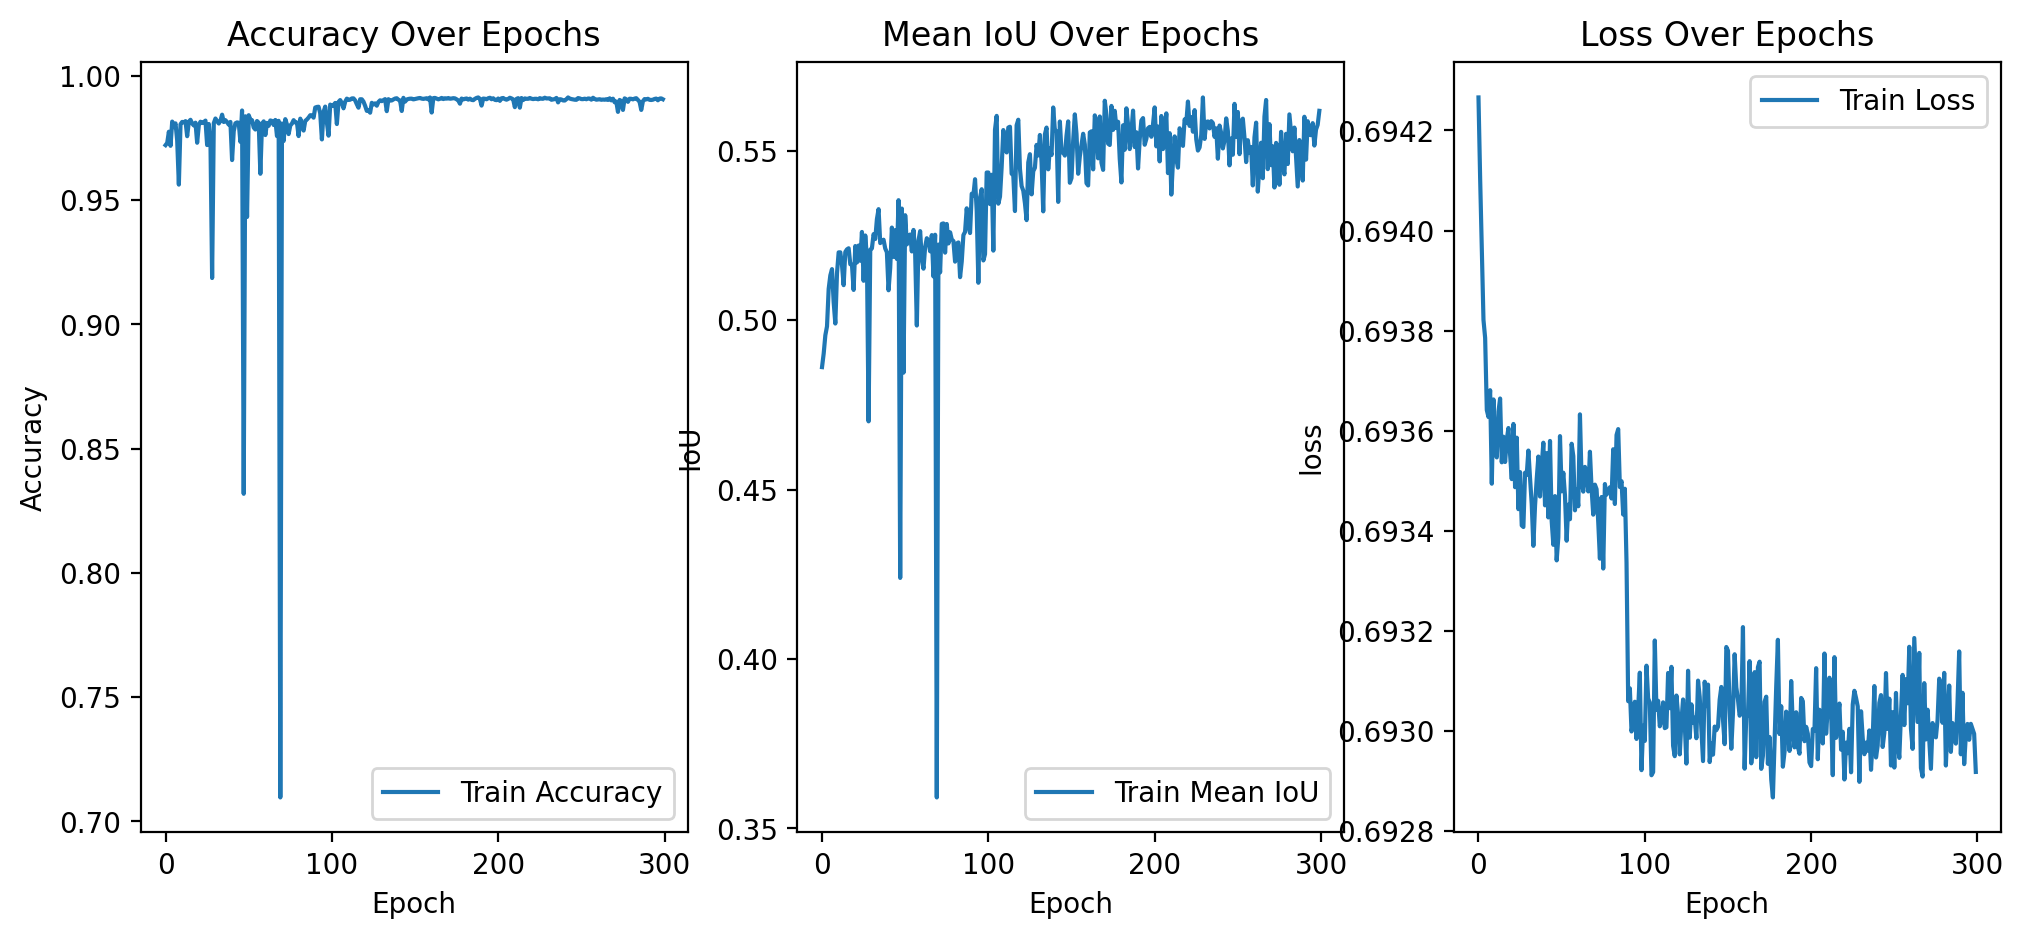

In [27]:
plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,3,2)
plt.plot(history.history['mean_iou'], label='Train Mean IoU')
plt.title("Mean IoU Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()

plt.subplot(1,3,3)
plt.plot(history.history['loss'], label='Train Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()

plt.show()

In [28]:
import numpy as np

mean_after_100 = np.mean(history.history['mean_iou'][100:])
print("mean IoU after 100 epoch:", mean_after_100)

mean IoU after 100 epoch: 0.551673866212368
